In [365]:
import scipy.io
import numpy as np
from numpy import cov
from numpy.linalg import eig as eigh
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from scipy.stats import multivariate_normal

## Task 1. Feature normalization (Data conditioning).

In [366]:
#load training data
train0= scipy.io.loadmat('training_data_0.mat')
train1=scipy.io.loadmat('training_data_1.mat')
#load testing data
test0=scipy.io.loadmat('testing_data_0.mat')
test1=scipy.io.loadmat('testing_data_1.mat')

In [367]:
def vectorize(NumberOfSample,data,number):
    new=data[number][:,:,0].flatten()
    for i in range(1,NumberOfSample):  
        new=np.vstack((new,data[number][:,:,i].flatten()))
    return new

In [368]:
train0_vec=vectorize(train0['nim0'].shape[2],train0,'nim0')
train1_vec=vectorize(train1['nim1'].shape[2],train1,'nim1')
test0_vec=vectorize(test0['nim0'].shape[2],test0,'nim0')
test1_vec=vectorize(test1['nim1'].shape[2],test1,'nim1')

In [369]:
train_all=np.vstack((train0_vec,train1_vec))
test_all=np.vstack((test0_vec,test1_vec))

In [370]:
def mean_std(VecArray):
    mean = np.mean(VecArray, axis=0)
    std = np.std(VecArray, axis=0)
    result=np.vstack((mean,std))
    return result

In [371]:
train_all_ms=mean_std(train_all)

In [372]:
def normalize(x,mean,std):
    return (x-mean)/std

In [373]:
def updateVec(train_vec,train_vec_ms):
    for i in range(train_vec.shape[1]):
        for j in range(train_vec.shape[0]):
            mean=train_vec_ms[:,i][0]
            std=train_vec_ms[:,i][1]
            train_vec[:,i][j]=normalize(train_vec[:,i][j],mean,std)
    return train_vec

In [374]:
#train samples
normalized_train_all=updateVec(train_all,train_all_ms)

In [375]:
#test samples
normalized_test_all=updateVec(test_all,train_all_ms)

In [399]:
normalized_train_all.shape,normalized_test_all.shape

((12665, 784), (2115, 784))

## Task 2. PCA using the training samples.

In [376]:
# Now, we will perfrom the PCA using the training samples
# Since I already did the feature normalization, there are two more steps
# Step2: computer covariance matrix
# Step3: Computer eigenvalue and eigenvector
# Step4: eigen analysis

In [377]:
#Assign label and combine normalized train data
label0=np.zeros((5923,1))
label1=np.ones((6742,1))
labels=np.vstack((label0,label1))
train=np.hstack((normalized_train_all,labels))

In [378]:
#Assign label and combine normalized test data
label0_test=np.zeros((980,1))
label1_test=np.ones((1135,1))
labels_test=np.vstack((label0_test,label1_test))
test=np.hstack((normalized_test_all,labels_test))

In [379]:
#split train and test data to do pca
#train
train_X=train[:,0:784]
train_label=train[:,784]

In [380]:
#test
test_X=test[:,0:784]
test_label=test[:,784]

In [381]:
# Step2: computer covariance matrix
# train_covar_matrix = np.matmul(train_X.T,train_X)
train_covar_matrix = np.cov(train_X.T)

In [382]:
train_covar_matrix.shape

(784, 784)

In [383]:
# Step3: Computer eigenvalue and eigenvector
train_values, train_vectors = np.linalg.eig(train_covar_matrix)

In [401]:
train_vectors.shape

(784, 784)

In [407]:
# Step4: eigen analysis
train_variances = []
for i in range(len(train_values)):
    train_variances.append(train_values[i] / np.sum(train_values))
#The first and second principle component    
print (train_variances[:2])

[0.1268632932745279, 0.050769186021883274]


In [385]:
train_vectorsT=train_vectors.T
frist_second_component=np.vstack((train_vectorsT[0],train_vectorsT[1]))
project_train = np.matmul(frist_second_component,train_X.T)
# new_coordinate_train=project_train.T*(-1)
new_coordinate_train=project_train.T

## Task 3. Dimension reduction using PCA.


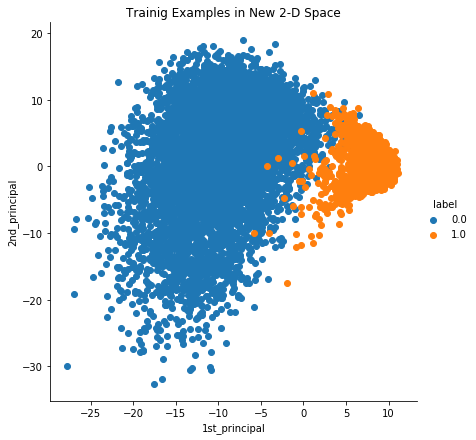

In [386]:
#Projec train sampels 
train_dataframe = pd.DataFrame(data=new_coordinate_train, columns=('1st_principal', '2nd_principal'))
train_dataframe['label']=train_label
sn.FacetGrid(train_dataframe, hue='label', height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend().set(title='Trainig Examples in New 2-D Space')
plt.show()

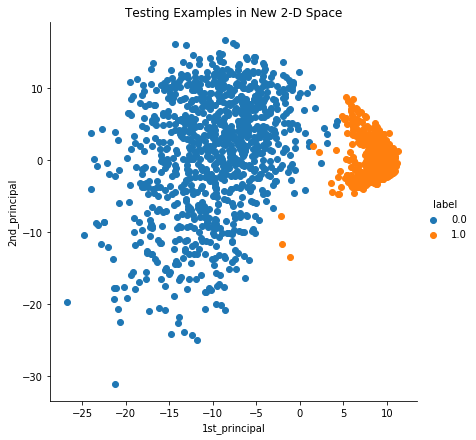

In [387]:
#Projec test sampels 
project_train = np.matmul(frist_second_component,test_X.T)
# new_coordinate_test=(project_train.T)*-1
new_coordinate_test=project_train.T
test_dataframe = pd.DataFrame(data=new_coordinate_test, columns=('1st_principal', '2nd_principal'))
test_dataframe['label']=test_label
sn.FacetGrid(test_dataframe, hue='label', height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend().set(title='Testing Examples in New 2-D Space')
plt.show()

## Task 4. Density estimation.

In [388]:
def DensityEstimation(train):
    mean = np.mean(train, axis=0)
    cov= np.cov(train.T)
    return [mean,cov]

In [389]:
# Becasue we assume in the 2-D space, samples from each class follow a Gaussian distribution.
# Then we just need to estimate the parameters for 2-d normal distribution for each class/digit
# Digit0: N~(µ0, Σ0)
train0_data=new_coordinate_train[:5923]
train0_variable=DensityEstimation(train0_data)

In [390]:
# Digit1: N~(µ1, Σ1)
train1_data=new_coordinate_train[5923:]
train1_variable=DensityEstimation(train1_data)

In [391]:
print("Parameter for train0 normal distribution:","mean:",train0_variable[0],"cov:",train0_variable[1])

Parameter for train0 normal distribution: mean: [-9.92384569  0.8514571 ] cov: [[25.32460567 15.90014464]
 [15.90014464 79.11311962]]


In [392]:
print("Parameter for train1 normal distribution:","mean:",train1_variable[0],"cov:",train1_variable[1])

Parameter for train1 normal distribution: mean: [ 8.71832365 -0.74802439] cov: [[ 2.06676736 -0.02148539]
 [-0.02148539  4.0841354 ]]


## Task 5. Bayesian Decision Theory for optimal classification.

In [393]:
#Predict since we using minimum-error-rate classification, 
#we decide class 0 if P(class0)*P(X|class0)>P(class1)*P(X|class1)
#Since P(class0)=P(class1)=0.5, we only need to compare P(X|class0) and P(X|class1)
def predict(train0_variable,train1_varibale,new_coordinate_test):
    p0_prio=0.5
    p1_prio=0.5
    result=[]
    var0 = multivariate_normal(mean=train0_variable[0],cov=train0_variable[1])
    var1 = multivariate_normal(mean=train1_variable[0],cov=train1_variable[1])
    for i in range(new_coordinate_test.shape[0]):
        p0=var0.pdf([new_coordinate_test[i][0],new_coordinate_test[i][1]])
        p1=var1.pdf([new_coordinate_test[i][0],new_coordinate_test[i][1]])   
        if (p0*p0_prio)>(p1*p1_prio):
            result.append(0)
        else:
            result.append(1)
    return result

In [394]:
predict_result_train=predict(train0_variable,train1_varibale,new_coordinate_train)
train_truth=list(train_label)
train_accuracy = len([predict_result_train[i] for i in range(0, len(predict_result_train)) if predict_result_train[i] == train_truth[i]]) / len(predict_result_train)
print("Training set accuracy:",train_accuracy)

Training set accuracy: 0.9887879984208449


In [395]:
predict_result=predict(train0_variable,train1_varibale,new_coordinate_test)
test_truth=list(test_label)
test_accuracy = len([predict_result[i] for i in range(0, len(predict_result)) if predict_result[i] == test_truth[i]]) / len(predict_result)
print("Testing set accuracy:",test_accuracy)

Testing set accuracy: 0.9919621749408983
